In [ ]:
#pip install keras_vggface


In [ ]:
#%pip install git+https://github.com/ufukbakan/keras-vggface-tensorflow-2.git

In [2]:
import os
import cv2
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# from keras_vggface import utils
# from keras_vggface.vggface import VGGFace

# Charger le dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# Chemin vers le dossier contenant les dossiers de célébrités
root_dir= '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/dataset'
classes_dir = os.listdir(root_dir)

# Réorganiser le dataset en train, val et dir

In [8]:
# Créer les dossiers de destination s'ils n'existent pas déjà
os.makedirs('/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/data/train', exist_ok=True)
os.makedirs('/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/data/val', exist_ok=True)
os.makedirs('/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_datset/data/test', exist_ok=True)

In [ ]:
# train_dir = 'root/train'
# val_dir = 'root/val'
# test_dir = 'root/test'

In [9]:
train_dir = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/data/train'
val_dir = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/data/val'
test_dir = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/data/test'

In [5]:
len(val_dir)


80

In [ ]:
len(train_dir)

79

In [ ]:
len(test_dir)

78

# Pré-Visualisation

In [10]:
classes_train = os.listdir(train_dir)
classes_train.sort()
classes_train

['User.1', 'User.2', 'User.3', 'User.4', 'User.5', 'User.6', 'User.7']

In [11]:
classes_test = os.listdir(test_dir)
classes_test.sort()
classes_test

['User.1', 'User.2', 'User.3', 'User.4', 'User.5', 'User.6', 'User.7']

In [12]:
classes_val = os.listdir(val_dir)
classes_val.sort()
classes_val

['User.1', 'User.2', 'User.3', 'User.4', 'User.5', 'User.6', 'User.7']

In [9]:
list = [classes_val, classes_test, classes_train]


# Utiliser la compréhension de liste pour trouver les éléments uniques à classes_train
unique_to_train = [item for item in classes_train if item not in classes_val]

# Afficher les éléments uniques
print("Items in classes_train that are not in classes_val:")
for item in unique_to_train:
    print(item)




Items in classes_train that are not in classes_val:


In [10]:
len(classes_val)

7

In [11]:
len(classes_train)

7

In [12]:
len(classes_test)

7

# Nettoyage

In [15]:

# Charger le modèle pré-entraîné pour la détection de visage d'OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/Haarcascades/haarcascade_frontalface_default.xml')

def clean_non_faces(dir):
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            image = cv2.imread(file_path)
            faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            if len(faces) == 0:
                os.remove(file_path)  # Deletes the file
                print(f"Deleted {file_path} -  pas de face detecté.")


for data in ['train_dir', 'val_dir', 'test_dir']:
    clean_non_faces(data)


In [17]:

# Charger le model
# configFile = "/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/models/opencv_face_detector.pbtxt"
# modelFile = "/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/models/opencv_face_detector_uint8.pb"

modelFile = "/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/models/deploy.prototxt.txt"
configFile = "/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/models/res10_300x300_ssd_iter_140000_fp16.caffemodel"

net = cv2.dnn.readNetFromCaffe(modelFile, configFile)

#net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)



def clean_non_faces(dir):
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            image = cv2.imread(file_path)

            # Create a blob and pass it through the model
            # blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
            #                              (300, 300), (104.0, 177.0, 123.0))

            blob = cv2.dnn.blobFromImage(image,1,(300,300),(104,177,123),swapRB=False)

            net.setInput(blob)
            detections = net.forward()

            h,w = image.shape[:2]
            for i in range(0,detections.shape[2]):
                confidence = detections[0,0,i,2]
                if confidence >= 0.5:
                    #print(confidence)
                    # bounding box (3:7)
                    box = detections[0,0,i,3:7] # normalized bounding box values
                    box = box*np.array([w,h,w,h])
                    box = box.astype(int)
                    startx, starty , endx, endy = box
                    # draw the rectangle
                    cv2.rectangle(image,(startx,starty),(endx,endy),(0,255,0))

                    # put text
                    text = 'Face: {:.2f} %'.format(confidence*100)
                    cv2.putText(image,text,(startx,starty-10),cv2.FONT_HERSHEY_PLAIN,1,(255,255,255),)


            # If no faces are detected
            if len(detections) == 0:
                os.remove(file_path)  # Deletes the file
                print(f"Deleted {file_path} - no face detected.")




In [18]:
 #Clean non-face images
clean_non_faces(train_dir)
clean_non_faces(val_dir)
clean_non_faces(test_dir)


# Création du modele

In [13]:

# Taille des images attendue
image_size = (250, 250)



# Création des générateurs d'images avec prétraitement de VGGFace

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
   rescale=1. / 255
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Gnénerateur data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=16,
    class_mode='categorical',
    )

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=16,
    class_mode='categorical',
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=16,
    class_mode='categorical',
    shuffle=False ) #ne pas mélanger l'ordre des images afin de faciliter la vérification



Found 128 images belonging to 7 classes.
Found 43 images belonging to 7 classes.
Found 43 images belonging to 7 classes.


In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Chargement du modèle précedent
model = load_model('/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_recognition2plus.h5')

#  couche dense finale nommée 'predictions'
model.layers.pop()  # Supprime la dernière couche
new_output_layer = Dense(len(classes_train), activation='softmax')(model.layers[-1].output)
model = Model(inputs=model.inputs, outputs=new_output_layer)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Congeler les couches du modèle de base pour l'entraînement
# for layer in base_model.layers:
#     layer.trainable = False

# # Compilation du modèle
# model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


ValueError: ignored

In [27]:
# Entraînement du modèle
history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50
)


Epoch 1/50
8/8 [==============================] - 20s 658ms/step - loss: 1.9320 - accuracy: 0.1875 - val_loss: 1.9086 - val_accuracy: 0.3125
Epoch 2/50
8/8 [==============================] - 3s 322ms/step - loss: 1.9247 - accuracy: 0.2031 - val_loss: 1.8824 - val_accuracy: 0.4688
Epoch 3/50
8/8 [==============================] - 2s 297ms/step - loss: 1.9062 - accuracy: 0.2969 - val_loss: 1.8740 - val_accuracy: 0.4688
Epoch 4/50
8/8 [==============================] - 4s 486ms/step - loss: 1.8963 - accuracy: 0.2891 - val_loss: 1.8483 - val_accuracy: 0.5625
Epoch 5/50
8/8 [==============================] - 4s 448ms/step - loss: 1.8814 - accuracy: 0.3672 - val_loss: 1.8392 - val_accuracy: 0.5312
Epoch 6/50
8/8 [==============================] - 2s 313ms/step - loss: 1.8668 - accuracy: 0.4297 - val_loss: 1.8413 - val_accuracy: 0.5312
Epoch 7/50
8/8 [==============================] - 2s 307ms/step - loss: 1.8676 - accuracy: 0.3906 - val_loss: 1.8348 - val_accuracy: 0.5625
Epoch 8/50
8/8 [===

In [28]:
# Évaluer le modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 [==============================] - 1s 630ms/step - loss: 1.3191 - accuracy: 0.8372
Test Accuracy: 83.72%


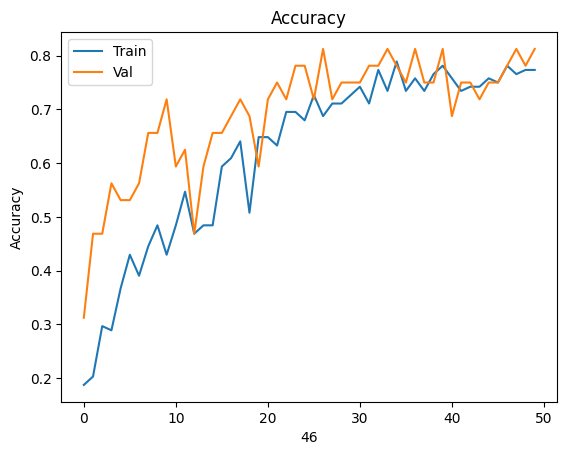

In [29]:
# Visualisation
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('46')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [31]:
model.save('face_recognise.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3_input (InputL  [(None, 250, 250, 3)]     0         
 ayer)                                                           
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 98)                100450    
                                                           

In [21]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
# Créer le générateur pour l'ensemble de test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important pour la correspondance des prédictions et des étiquettes
)

Found 43 images belonging to 7 classes.


In [25]:
# test de prediction:
from PIL import Image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import  img_to_array


# Chemin vers le modèle sauvegardé et le dossier de validation
model_path = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/face_recognise.h5' # model
file_path1 = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/data/test/User.1/1.1.jpg'
file_path2 = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/dataset/User.3/3.10.jpg'
file_path3 = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/dataset/User.5/6.3.jpg'
file_path4 = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/dataset/User.5/7.27.jpg'
file_path5 = '/content/drive/MyDrive/ProjetIA/Real_time_face_recognition/face_dataset/dataset/User.7/9.10.jpg'

model = load_model(model_path)

# Taille des images attendue par le modèle
image_size = (250,250)

def load_and_preprocess_image(file_path, target_size=image_size):
    # Charger l'image avec PIL
    img = Image.open(file_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    # Ajouter une dimension de batch
    img_array = np.expand_dims(img_array, axis=0)
    img_processed =  preprocess_input(img_array)

    return img_processed

image1 = load_and_preprocess_image(file_path1)
prediction1 = model.predict(image1)

image2 = load_and_preprocess_image(file_path2)
prediction2 = model.predict(image2)

image3 = load_and_preprocess_image(file_path3)
prediction3 = model.predict(image3)

image4 = load_and_preprocess_image(file_path4)
prediction4 = model.predict(image4)

image5 = load_and_preprocess_image(file_path5)
prediction5 = model.predict(image5)

1/1 [==============================] - 0s 42ms/step


In [26]:
np.argmax(prediction1)


1

In [27]:
np.argmax(prediction2)

2

In [28]:
np.argmax(prediction3)

4

In [29]:
np.argmax(prediction4)

4

In [30]:
np.argmax(prediction5)

5

In [ ]:
# Prédire les classes des images avec le modèle
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)


38/38 [==============================] - 10s 230ms/step


In [ ]:
# Obtenir les étiquettes de classe prédites
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
# Vraies étiquettes
true_classes = test_generator.classes

# Calcul de l'accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Test Accuracy : {accuracy*100:.2f}%")


Test Accuracy : 35.69%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes  # étiquettes réelles

y_pred = predicted_classes
y_pred = (y_pred > 0.5).astype(int)

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Calcul de la précision
accuracy = accuracy_score(y_true, y_pred)

# Calcul du rappel (sensibilité)
recall = recall_score(y_true, y_pred, average='micro')

# Calcul de la précision
precision = precision_score(y_true, y_pred, average='micro')

# Calcul du score F1
f1 = f1_score(y_true, y_pred, average='micro')


print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


# # Afficher la matrice de confusion
# conf_matrix = confusion_matrix(true_classes, predicted_classes)
# print(conf_matrix)

# # Afficher le rapport de classification
# report = classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)


Accuracy: 0.01430976430976431
Recall: 0.01430976430976431
Precision: 0.01430976430976431
F1 Score: 0.01430976430976431


# Conclusion
Choix du modèle: Le model2 basé sur InceptionV3 possède une accuracy d'environ 50% et une val_accuracy qui dépasse 54%, ce qui est insuffisant pour identifier correctement les images. En revanche le modèle a reussi à identifier correctement toutes les images testées prélevées de test_dir.



---

